# Clustering Test

In [13]:
import pandas as pd
import numpy as np
import concurrent.futures as cf
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from collections import Counter

pd.set_option('display.max_columns', None)

%matplotlib inline

In [33]:
path_in = '~/Dropbox/Burning Glass/Data/random_data/'
path_out = '~/Dropbox/Burning Glass/Analysis/unsupervised_approach/'

In [3]:
%%time

df = pd.read_csv(path_in + 'all_years_rand_samp.csv', 
                 parse_dates=['JobDate'], low_memory=False)
df.head()

CPU times: user 16.8 s, sys: 6.91 s, total: 23.7 s
Wall time: 29.2 s


,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience
0,en,Irvine,CA,Pt Faculty Pool - Recycling & Zero Waste,2013-01-03,Posting Details South Orange County Community ...,110103522,33.6881,-117.7880,92604,Orange,11244.0,DV064204|MT063110,31080: Metropolitan Statistical Area|348: Comb...,Saddleback College,NaN,25-119900,NaN,0,Education,Education and Training: Instructional and Curr...,{'Course Development': 'Education and Training...,False,Bachelor of Arts,Bachelor of Arts|Bachelor's|Master's,030103,6.0,6113.0,25-1199.91,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,16|18,Pt Faculty Pool - Recycling & Zero Waste,18.0,16.0,College Professor / Instructor,2) years|6) years|Two years
1,en,Marbury,MD,Class A Cdl Truck Driver,2013-11-20,Experienced Class A CDL Truck Drivers (20658),255851194,38.5624,-77.1639,20658,Charles,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,Usa Truck,Class A CDL Truck Driver,53-303200,NaN,0,Job Board,NaN,{},False,NaN,NaN,NaN,NaN,484.0,53-3032.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class A CDL Truck Driver,NaN,NaN,Tractor-Trailer Truck Driver (General),NaN
2,en,Auburn,AL,Apartment Community Maintenance Technician - S...,2013-09-06,"Posted: 2013-09-05, 4:16PM EDT\n\nApartment Co...",246911326,32.5824,-85.5126,36830,Lee,NaN,MT011222,12220: Metropolitan Statistical Area,NaN,Maintenance Technician,49-907100,NaN,0,FreeJobBoard,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,Higher Secondary Certificate,NaN,2.0,NaN,49-9071.91,NaN,NaN,NaN,NaN,NaN,NaN,1-6,mid,12,Maintenance Technician,NaN,12.0,Building and General Maintenance Technician,minimum of six months|two years
3,en,Anchorage,AK,Registered Nurse - All Specialties And Shifts,2013-08-30,Description:\n* Registered Nurses - All Spec...,244857419,61.2157,-149.8690,99501,Anchorage,NaN,MT021126,11260: Metropolitan Statistical Area,Nadiagruzd,Registered Nurse,29-114100,NaN,0,Recruiter,NaN,{},False,NaN,NaN,NaN,NaN,62.0,29-1141.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Registered Nurse,NaN,NaN,Registered Nurse,NaN
4,en,Madison,WI,Project Manager,2013-11-30,"Apex Systems, Inc Skills: Project ma...",420796045,43.1153,-89.5249,53562,Dane,NaN,MT553154,31540: Metropolitan Statistical Area,NaN,NaN,15-119909,"Apex Systems, Inc.",0,Job intermediary,Finance: Cost Accounting;Specialized Skills|Ma...,{'Cost Analysis': 'Finance: Cost Accounting;Sp...,False,NaN,NaN,NaN,7.0,NaN,15-1199.95,NaN,NaN,NaN,NaN,fulltime,permanent,6+,high,NaN,Project Manager,NaN,NaN,IT Project Manager,7 years|5 years|3 years


# Data Inspection & Cleaning

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476428 entries, 0 to 476427
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Language                          476428 non-null  object        
 1   CanonCity                         466244 non-null  object        
 2   CanonState                        476394 non-null  object        
 3   CleanJobTitle                     476269 non-null  object        
 4   JobDate                           476428 non-null  datetime64[ns]
 5   JobText                           473483 non-null  object        
 6   JobID                             476428 non-null  int64         
 7   Latitude                          466253 non-null  float64       
 8   Longitude                         466253 non-null  float64       
 9   CanonPostalCode                   465000 non-null  object        
 10  CanonCounty                     

In [5]:
df.shape

(476428, 43)

In [6]:
missing_pct = df.isna().sum() / df.shape[0] * 100
missing_pct

Language                             0.000000
CanonCity                            2.137574
CanonState                           0.007136
CleanJobTitle                        0.033373
JobDate                              0.000000
JobText                              0.618142
JobID                                0.000000
Latitude                             2.135685
Longitude                            2.135685
CanonPostalCode                      2.398684
CanonCounty                          2.159403
DivisionCode                        68.090666
LMA                                  2.479073
MSA                                  4.781625
CanonEmployer                       36.437405
CanonJobTitle                       35.178453
ConsolidatedONET                     3.593618
CanonIntermediary                   85.666040
InternshipFlag                       0.000000
Source                               3.168789
CanonSkillClusters                   8.660700
CanonSkills                       

A lot of the missing values in the `CanonEmployer` variable might be missing due to the job being posted through a recruiting agency. Let's see how many of these missing value have a value available in the `CanonIntermediary` column.

In [7]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), :].shape

(68284, 43)

As we can see, about ~68,000 missing values in `CanonEmployer` have a matching Recruiting Agency in `CanonIntermediary`.

In [8]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), ['CanonEmployer', 'CanonIntermediary']].head()

,CanonEmployer,CanonIntermediary
4,NaN,"Apex Systems, Inc."
10,NaN,Nigel Frank International
12,NaN,Kelly Services
20,NaN,Elance
31,NaN,Randstad


In [9]:
df.shape[0] * .15

71464.2

We can also see that the `CanonIntermediary` variable has about `0.15` of non-missing values in it, which is almost the same amount of values missing in the `CanonEmployer` var. Instead of filling in each missing value `CanonEmployer` with its respective recruiting agency for that title, what we will do instead is to fill in those missing values with the title, `Recruiting Agency`.

In [10]:
print(f'Missing companies BEFORE adding the Recruitment Agencies: {df.CanonEmployer.isna().sum()}')

Missing companies BEFORE adding the Recruitment Agencies: 173598


In [11]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), 'CanonEmployer'] = 'Recruiting Agency'

In [12]:
print(f'Missing companies AFTER adding the Recruitment Agencies: {df.CanonEmployer.isna().sum()}')

Missing companies AFTER adding the Recruitment Agencies: 105314


In [13]:
print('Amount of Unique Employers: ', len(df['CanonEmployer'].unique()))

Amount of Unique Employers:  75805


In [14]:
# to_drop_cols = (missing_pct[missing_pct > 75]).index
# print(to_drop_cols)
# df.drop(to_drop_cols, axis=1, inplace=True)
# print(df.shape)

In [15]:
print('Amount of Unique Jobs: ', len(df['CleanJobTitle'].unique()))

Amount of Unique Jobs:  271225


In [16]:
print('Percentage of Unique Jobs in the Dataset: %.2f' % (len(df['CleanJobTitle'].unique()) / df.shape[0] * 100))

Percentage of Unique Jobs in the Dataset: 56.93


In [17]:
df['year'] = df['JobDate'].dt.year
print("Observations per Year")
df['year'].value_counts()

Observations per Year


2011    50144
2012    49926
2007    47695
2016    43376
2015    40945
2010    40487
2017    39534
2020    35000
2019    35000
2018    35000
2014    33690
2013    25631
Name: year, dtype: int64

# More Cleaning

In [18]:
df = df[df['CanonEmployer'].notna()]
df = df[df['JobText'].notna()]
df = df[df['CleanJobTitle'].notna()]

In [19]:
df.shape

(368555, 44)

In [20]:
df['clean_text'] = df['JobText'].apply(lambda x: ' '.join(list(filter(None, x.split('\n')))))
df['charac_text_len'] = df['clean_text'].apply(len)
df['low_clean'] = df['clean_text'].apply(lambda x: x.lower())

In [21]:
df['list_job_text'] = df['clean_text'].apply(lambda x: list(filter(None, x.split())))
df['list_title_words'] = df['CleanJobTitle'].apply(lambda x: list(filter(None, x.split())))

In [22]:
df['len_job_text'] = df['list_job_text'].apply(len)

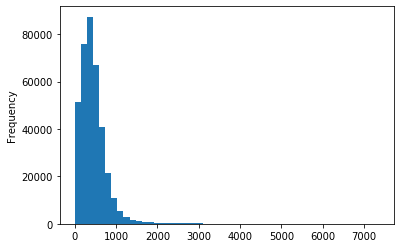

In [23]:
df['len_job_text'].plot(kind='hist', bins=50)

In [24]:
df['len_job_text'].describe()

count    368555.000000
mean        442.574134
std         336.774133
min           1.000000
25%         233.000000
50%         391.000000
75%         578.000000
max        7370.000000
Name: len_job_text, dtype: float64

In [25]:
df = df.loc[df['len_job_text'] > 75]
df.shape

(342332, 49)

In [26]:
df['len_job_text'].describe()

count    342332.000000
mean        474.721735
std         327.921201
min          76.000000
25%         269.000000
50%         413.000000
75%         595.000000
max        7370.000000
Name: len_job_text, dtype: float64

# Select Random Sample of 100K

The `.sample()` method below can be adjusted to whichever `n` sample you'd like. Also, note that unless you save the sample you are taking from the slightly larger data, every time you run this notebook you will get slightly different results as the sample will change.

In [27]:
df = df.sample(n=100000)
df = df[['JobDate', 'CanonEmployer', 'CleanJobTitle', 'clean_text']]
df.reset_index(drop=True, inplace=True)
df.head()

,JobDate,CanonEmployer,CleanJobTitle,clean_text
0,2019-05-16,Heartland Express Incorporated,Class A Cdl Truck Driver,Class A CDL Truck Driver - Auburn Company: Hea...
1,2020-02-07,Department General Services,Custodian Worker,Custodian Worker Department of General Service...
2,2011-06-30,Gateway Health System,Medical Technologist - Medical Technician 80Hr...,Go to the main content section. Welcome. You a...
3,2012-06-12,Christus Coushatta Health Care Center,Human Resources Specialist Fmla And Leave *,Job Title: HR Specialist (FMLA and leave)* Jo...
4,2007-01-21,First Assist Incorporated,Cath Laboratory - Registered Nurse,Cath Lab RN - Registered Nurse - (US- - ) Min ...


Let's make sure there are no missing values in this random sample.

In [28]:
df.isna().any()

JobDate          False
CanonEmployer    False
CleanJobTitle    False
clean_text       False
dtype: bool

In [30]:
def normalize_doc(doc):
    """
    This function normalizes your list of documents by taking only
    words, numbers, and spaces in between them. It then filters out
    stop words if you want to.
    """
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens]
    # if you want to remove stopwords, uncomment the line below and
    # comment out the one above
    # filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

corp_normalizer = np.vectorize(normalize_doc)

In [31]:
%%time

normal_corpus = corp_normalizer(list(df['clean_text']))

CPU times: user 3min 18s, sys: 26.4 s, total: 3min 45s
Wall time: 4min 3s


In [32]:
normal_corpus.shape

(100000,)

In [33]:
normal_corpus[6]

'skills red hat linux 5x websphere weblogic andor apache vmwarevsphere date 5272011 location ashburn va area code 571 employ type concorp conind conw2 pay rate negotiable job length 6 months position id linwinadmin dice id 10118406 travel required none telecommute no contact information save this job click here to apply printerfriendly job description linuxwindows server 2008 administrator multiple openings ashburn va note if you are comfortable with the below requirements please forward your resume with requirement to jobsloginsoftconsultingcom or give a call at 7039567410 extn 55005523 requirement 1 unixlinux system administrator multiple positions in different locations location ashburn va and temple terrace fl or freehold nj key requirements job skills mandatory experience installing and configuring red hat linux 5x 3 years rhel 55 preferred experience installing and configuring websphere weblogic andor apache experience working with vmwarevsphere or experience with network attache

In [38]:
df['normal_text'] = normal_corpus

In [34]:
%%time

normal_titles = corp_normalizer(list(df['CleanJobTitle']))

CPU times: user 7.8 s, sys: 251 ms, total: 8.05 s
Wall time: 8.44 s


In [35]:
normal_titles.shape

(100000,)

In [36]:
normal_titles[0]

'class a cdl truck driver'

In [39]:
df['normal_titles'] = normal_titles

In [40]:
sample_name = 'rands_100k.csv'

In [43]:
df.head()

,JobDate,CanonEmployer,CleanJobTitle,clean_text,normal_text,normal_titles
0,2019-05-16,Heartland Express Incorporated,Class A Cdl Truck Driver,Class A CDL Truck Driver - Auburn Company: Hea...,class a cdl truck driver auburn company heartl...,class a cdl truck driver
1,2020-02-07,Department General Services,Custodian Worker,Custodian Worker Department of General Service...,custodian worker department of general service...,custodian worker
2,2011-06-30,Gateway Health System,Medical Technologist - Medical Technician 80Hr...,Go to the main content section. Welcome. You a...,go to the main content section welcome you are...,medical technologist medical technician 80hr 2...
3,2012-06-12,Christus Coushatta Health Care Center,Human Resources Specialist Fmla And Leave *,Job Title: HR Specialist (FMLA and leave)* Jo...,job title hr specialist fmla and leave job cod...,human resources specialist fmla and leave
4,2007-01-21,First Assist Incorporated,Cath Laboratory - Registered Nurse,Cath Lab RN - Registered Nurse - (US- - ) Min ...,cath lab rn registered nurse us min education ...,cath laboratory registered nurse


In [42]:
%%time

df.to_csv(path_in + sample_name, index=False)

CPU times: user 13.5 s, sys: 1.97 s, total: 15.5 s
Wall time: 17.2 s


# Section I - Getting the Data and our Text Matrices

In [90]:
len(df['CleanJobTitle'].unique())

66924

In [15]:
stopwords = nltk.corpus.stopwords.words('english')

In [16]:
%%time

sample_name = 'rands_100k.csv'

df = pd.read_csv(path_in + sample_name, low_memory=False)
df.head()

CPU times: user 4.05 s, sys: 821 ms, total: 4.88 s
Wall time: 4.96 s


,JobDate,CanonEmployer,CleanJobTitle,clean_text,normal_text,normal_titles
0,2019-05-16,Heartland Express Incorporated,Class A Cdl Truck Driver,Class A CDL Truck Driver - Auburn Company: Hea...,class a cdl truck driver auburn company heartl...,class a cdl truck driver
1,2020-02-07,Department General Services,Custodian Worker,Custodian Worker Department of General Service...,custodian worker department of general service...,custodian worker
2,2011-06-30,Gateway Health System,Medical Technologist - Medical Technician 80Hr...,Go to the main content section. Welcome. You a...,go to the main content section welcome you are...,medical technologist medical technician 80hr 2...
3,2012-06-12,Christus Coushatta Health Care Center,Human Resources Specialist Fmla And Leave *,Job Title: HR Specialist (FMLA and leave)* Jo...,job title hr specialist fmla and leave job cod...,human resources specialist fmla and leave
4,2007-01-21,First Assist Incorporated,Cath Laboratory - Registered Nurse,Cath Lab RN - Registered Nurse - (US- - ) Min ...,cath lab rn registered nurse us min education ...,cath laboratory registered nurse


In [ ]:
def kmeans_algo_pipe(model, num_clus, vectorizer, , data, column, stop_w: bool=True) -> pd.DataFrame:
    
    vectorizer = vectorizer()
    
    km = model()

# Section II: Clustering the Titles

## KMeans Approach the BOW-WOW 😮 Way

In [17]:
count_vect_uni = CountVectorizer(ngram_range=(1, 1)) 
count_vect_bi = CountVectorizer(ngram_range=(1, 2))
count_vect_tri = CountVectorizer(ngram_range=(1, 3))

cv_titles_uni = count_vect_uni.fit_transform(df['CleanJobTitle'])
cv_titles_bi = count_vect_bi.fit_transform(df['CleanJobTitle']) 
cv_titles_tri = count_vect_tri.fit_transform(df['CleanJobTitle'])

cv_titles_uni.shape, cv_titles_bi.shape, cv_titles_tri.shape

((100000, 16796), (100000, 107256), (100000, 217631))

In [23]:
str(cvs[0])[3:]

'0, 3298)\t1\n  (0, 3646)\t1\n  (0, 5256)\t1\n  (0, 15606)\t1\n  (1, 4537)\t1\n  (1, 16617)\t1\n  (2, 552)\t1\n  (2, 691)\t1\n  (2, 984)\t1\n  (2, 9686)\t2\n  (2, 15089)\t1\n  (2, 15107)\t1\n  (3, 1685)\t1\n  (3, 6408)\t1\n  (3, 7616)\t1\n  (3, 8909)\t1\n  (3, 13017)\t1\n  (3, 14319)\t1\n  (4, 3227)\t1\n  (4, 8744)\t1\n  (4, 10664)\t1\n  (4, 12784)\t1\n  (5, 9400)\t1\n  (5, 9476)\t1\n  (5, 13726)\t1\n  :\t:\n  (99993, 10986)\t1\n  (99994, 5736)\t1\n  (99994, 7540)\t1\n  (99994, 13776)\t1\n  (99995, 2160)\t1\n  (99995, 9400)\t1\n  (99995, 13776)\t2\n  (99995, 15493)\t1\n  (99996, 1685)\t1\n  (99996, 2953)\t1\n  (99996, 4911)\t1\n  (99996, 5017)\t1\n  (99996, 9476)\t1\n  (99996, 12778)\t1\n  (99996, 14627)\t1\n  (99997, 9400)\t1\n  (99997, 12143)\t1\n  (99998, 1657)\t1\n  (99998, 3960)\t1\n  (99998, 4387)\t1\n  (99998, 10544)\t1\n  (99999, 7863)\t1\n  (99999, 13021)\t1\n  (99999, 13328)\t1\n  (99999, 15269)\t1'

In [18]:
%%time

num_clusters = [30, 35, 40, 45, 50, 55, 60]
cvs = [cv_titles_uni, cv_titles_bi, cv_titles_tri]

for i in range(len(num_clusters)):
    
    for s in cvs:
        km = KMeans(n_clusters=num_clusters[i], # how many clusters do we want
            max_iter=10000, # reshuffle each centroid x number of times
            n_init=25, # that x num of times can be set here
            random_state=42,
            n_jobs=2 # number of cpu's to use in the computation
           )
        
        
        km.fit(s)
        
        df[str(s)[3:] + '_' + str(i)] = km.labels_
    
    print(f"Done with k = {num_clusters[i]}")

Done with k=0


/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Done with k=1
Done with k=2
Done with k=3
Done with k=4
Done with k=5
Done with k=6
CPU times: user 32.4 s, sys: 58.4 s, total: 1min 30s
Wall time: 2h 22min 2s


In [29]:
len(df.columns)

27

In [30]:
df.columns = ['JobDate', 'CanonEmployer', 'CleanJobTitle', 
                    'clean_text', 'normal_text', 'normal_titles',
                    'km_uni_30', 'km_bi_30', 'km_tri_30',
                    'km_uni_35', 'km_bi_35', 'km_tri_35',
                    'km_uni_40', 'km_bi_40', 'km_tri_40',
                    'km_uni_45', 'km_bi_45', 'km_tri_45',
                    'km_uni_50', 'km_bi_50', 'km_tri_50',
                    'km_uni_55', 'km_bi_55', 'km_tri_55',
                    'km_uni_60', 'km_bi_60', 'km_tri_60']

In [31]:
df.columns

Index(['JobDate', 'CanonEmployer', 'CleanJobTitle', 'clean_text',
       'normal_text', 'normal_titles', 'km_uni_30', 'km_bi_30', 'km_tri_30',
       'km_uni_35', 'km_bi_35', 'km_tri_35', 'km_uni_40', 'km_bi_40',
       'km_tri_40', 'km_uni_45', 'km_bi_45', 'km_tri_45', 'km_uni_50',
       'km_bi_50', 'km_tri_50', 'km_uni_55', 'km_bi_55', 'km_tri_55',
       'km_uni_60', 'km_bi_60', 'km_tri_60'],
      dtype='object')

In [32]:
df.head()

,JobDate,CanonEmployer,CleanJobTitle,clean_text,normal_text,normal_titles,km_uni_30,km_bi_30,km_tri_30,km_uni_35,km_bi_35,km_tri_35,km_uni_40,km_bi_40,km_tri_40,km_uni_45,km_bi_45,km_tri_45,km_uni_50,km_bi_50,km_tri_50,km_uni_55,km_bi_55,km_tri_55,km_uni_60,km_bi_60,km_tri_60
0,2019-05-16,Heartland Express Incorporated,Class A Cdl Truck Driver,Class A CDL Truck Driver - Auburn Company: Hea...,class a cdl truck driver auburn company heartl...,class a cdl truck driver,29,25,10,26,2,30,5,2,25,11,25,25,11,25,25,46,2,3,46,2,59
1,2020-02-07,Department General Services,Custodian Worker,Custodian Worker Department of General Service...,custodian worker department of general service...,custodian worker,20,22,1,4,5,1,0,5,14,21,22,14,21,22,14,37,4,11,37,4,11
2,2011-06-30,Gateway Health System,Medical Technologist - Medical Technician 80Hr...,Go to the main content section. Welcome. You a...,go to the main content section welcome you are...,medical technologist medical technician 80hr 2...,0,12,1,5,21,1,28,21,0,6,39,0,6,39,0,35,26,39,35,26,39
3,2012-06-12,Christus Coushatta Health Care Center,Human Resources Specialist Fmla And Leave *,Job Title: HR Specialist (FMLA and leave)* Jo...,job title hr specialist fmla and leave job cod...,human resources specialist fmla and leave,3,3,21,25,10,21,25,10,6,10,3,6,10,3,6,27,40,34,27,40,34
4,2007-01-21,First Assist Incorporated,Cath Laboratory - Registered Nurse,Cath Lab RN - Registered Nurse - (US- - ) Min ...,cath lab rn registered nurse us min education ...,cath laboratory registered nurse,2,10,14,11,0,14,4,0,7,13,10,7,13,10,7,52,0,16,52,0,16


In [34]:
df.to_csv(path_out + 'kmeans_titles_approach_100k.csv', index=False)

In [35]:
(df.drop_duplicates()
   .sample(2000)
   .to_csv(path_out + 'kmeans_titles_approach_2k_unique.csv', index=False))

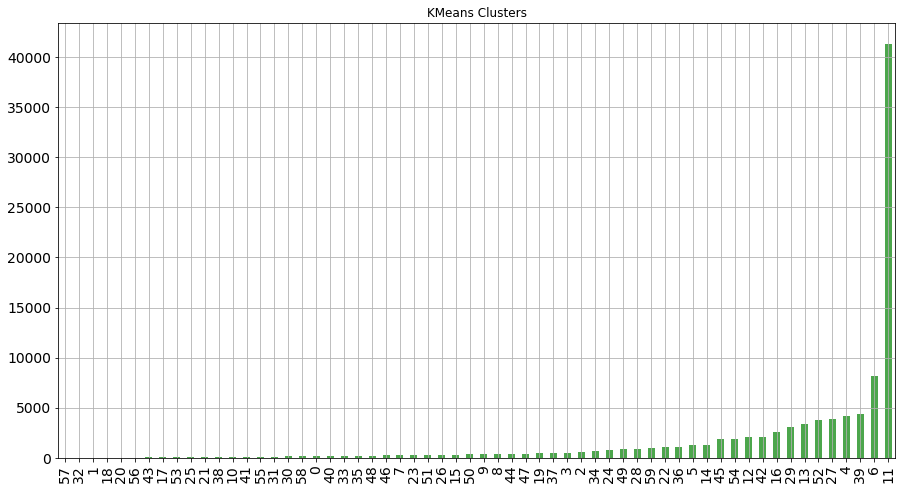

In [36]:
pd.Series(Counter(km.labels_)).sort_values().plot(kind='bar',
                                    rot=90, 
                                    figsize=(15, 8),
                                    fontsize=14,
                                    color='green',
                                    title='KMeans Clusters',
                                    grid=True,
                                    alpha=0.70);

In [37]:
df.loc[df['km_bi_30'] == 11, 'CleanJobTitle'].head(20)

2423                  Pt Produce Associate - Food Lion
2994        Pt Frozen Food/Dairy Associate - Food Lion
3506                  Pt Grocery Associate - Food Lion
4414                    Pt Sales Associate - Food Lion
5269           Center Store Grocery Manager- Food Lion
7764                Pt Perishable Associate- Food Lion
9234        Pt Quality Assurance Associate - Food Lion
9789     Pt Center Store Grocery Associate - Food Lion
12078                   Pt Sales Associate - Food Lion
14725                          Meat Cutter - Food Lion
15403                         Dsd Receiver - Food Lion
15557                          Meat Cutter - Food Lion
15770                 Pt Grocery Associate - Food Lion
15888             Pt Deli/Bakery Associate - Food Lion
17862             Dry Lead And Trainer Asm - Food Lion
18322                 Pt Service Associate - Food Lion
19441                Deli/Bakery Associate - Food Lion
19995             Pt Deli/Bakery Associate - Food Lion
20113     

In [132]:
title_clusters = (df[['CleanJobTitle', 'km_clusters']].sort_values(by=['km_clusters'], ascending=False).groupby('km_clusters').head(20))


title_clusters = title_clusters.copy(deep=True)
feature_names = count_vect.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [135]:
for cluster_num in range(num_clusters):
    key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :topn_features]]
    
    titles = title_clusters[title_clusters['km_clusters'] == cluster_num]['CleanJobTitle'].values.tolist()
    
    print('CLUSTER #'+ str(cluster_num + 1))
    print('Key Words:', key_features)
    print('Common Titles:', titles)
    print('-'*80)

SyntaxError: invalid character in identifier (<ipython-input-135-aeed7d93c717>, line 3)

## KMeans Approach the TF-IDF (TGIF) 😃🙌🏼 Way

# K-Nearest Neighbors

In [79]:
from sklearn.neighbors import NearestNeighbors

In [87]:
knn = NearestNeighbors(n_neighbors=50,
                       metric='euclidean',
                       algorithm='brute',
                       n_jobs=4,
                      )

In [88]:
knn.fit(cv_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=4, n_neighbors=5, p=2, radius=1.0)

# Section III - Clustering the Job Descriptions

For this section we will use a 10k random sample.

In [38]:
df.columns

Index(['JobDate', 'CanonEmployer', 'CleanJobTitle', 'clean_text',
       'normal_text', 'normal_titles', 'km_uni_30', 'km_bi_30', 'km_tri_30',
       'km_uni_35', 'km_bi_35', 'km_tri_35', 'km_uni_40', 'km_bi_40',
       'km_tri_40', 'km_uni_45', 'km_bi_45', 'km_tri_45', 'km_uni_50',
       'km_bi_50', 'km_tri_50', 'km_uni_55', 'km_bi_55', 'km_tri_55',
       'km_uni_60', 'km_bi_60', 'km_tri_60'],
      dtype='object')

In [40]:
%%time

small_df = df.sample(5000).copy()

CPU times: user 11.8 ms, sys: 15.9 ms, total: 27.6 ms
Wall time: 33.3 ms


In [42]:
small_df.shape

(5000, 27)

In [45]:
%%time

count_vect_uni = CountVectorizer(ngram_range=(1, 1), min_df=10, max_df=0.85) 
count_vect_bi = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.85)
count_vect_tri = CountVectorizer(ngram_range=(1, 3), min_df=10, max_df=0.85)

cv_text_uni = count_vect_uni.fit_transform(small_df['normal_text'])
cv_text_bi = count_vect_bi.fit_transform(small_df['normal_text']) 
cv_text_tri = count_vect_tri.fit_transform(small_df['normal_text'])

cv_text_uni.shape, cv_text_bi.shape, cv_text_tri.shape

CPU times: user 20.9 s, sys: 1.53 s, total: 22.4 s
Wall time: 23.3 s


((5000, 8175), (5000, 34051), (5000, 49186))

In [46]:
cvs_names = ['cv_text_uni', 'cv_text_bi', 'cv_text_tri']

cvs_names[0][3:]

'text_uni'

In [47]:
%%time

num_clusters = [30, 35, 40, 45, 50, 55, 60]
cvs = [cv_text_uni, cv_text_bi, cv_text_tri]
cvs_names = ['cv_text_uni', 'cv_text_bi', 'cv_text_tri']

for i in range(len(num_clusters)):
    
    for s, r in zip(cvs, cvs_names):

        km = KMeans(n_clusters=num_clusters[i], # how many clusters do we want
            max_iter=10000, # reshuffle each centroid x number of times
            n_init=25, # that x num of times can be set here
            random_state=42,
            n_jobs=2 # number of cpu's to use in the computation
           )
        
        
        km.fit(s)
        
        small_df[r[3:] + '_' + str(i)] = km.labels_
    
    print(f"Done with k = {num_clusters[i]}")

Done with k = 30
Done with k = 35
Done with k = 40
Done with k = 45
Done with k = 50
Done with k = 55
Done with k = 60
CPU times: user 9.94 s, sys: 16.5 s, total: 26.4 s
Wall time: 9h 33min 54s


In [48]:
small_df.head()

,JobDate,CanonEmployer,CleanJobTitle,clean_text,normal_text,normal_titles,km_uni_30,km_bi_30,km_tri_30,km_uni_35,km_bi_35,km_tri_35,km_uni_40,km_bi_40,km_tri_40,km_uni_45,km_bi_45,km_tri_45,km_uni_50,km_bi_50,km_tri_50,km_uni_55,km_bi_55,km_tri_55,km_uni_60,km_bi_60,km_tri_60,text_uni_0,text_bi_0,text_tri_0,text_uni_1,text_bi_1,text_tri_1,text_uni_2,text_bi_2,text_tri_2,text_uni_3,text_bi_3,text_tri_3,text_uni_4,text_bi_4,text_tri_4,text_uni_5,text_bi_5,text_tri_5,text_uni_6,text_bi_6,text_tri_6
57569,2007-11-04,Recruiting Agency,Manufacturing Device Technician,Manufacturing Device Technician: Kforce Scient...,manufacturing device technician kforce scienti...,manufacturing device technician,0,12,1,23,21,1,37,21,0,6,42,0,6,42,0,35,26,39,35,26,39,1,21,24,1,32,34,35,32,34,27,42,34,10,2,34,45,5,28,30,2,21
56128,2011-08-12,Parexel,Administrative Assistant,Home News Headlines Jobs by Location Jobs by T...,home news headlines jobs by location jobs by t...,administrative assistant,17,16,29,24,18,29,6,18,36,27,36,36,27,36,36,30,42,24,30,42,24,6,18,9,6,11,28,1,11,28,14,11,28,27,14,28,4,32,6,16,30,29
38191,2012-02-09,Mayo Foundation for Medical Education and Rese...,Unit Secretary,Main Navigation Sub Navigation Search by Keywo...,main navigation sub navigation search by keywo...,unit secretary,20,1,1,4,33,1,0,33,14,21,42,14,21,42,14,6,51,11,6,51,11,6,15,24,6,32,34,35,32,34,4,32,41,27,14,34,4,32,6,30,30,21
71088,2017-10-19,Recruiting Agency,Assembler,"Assembler Monday, october 16, 2017 Description...",assembler monday october 16 2017 description a...,assembler,20,1,1,4,33,1,0,33,14,26,42,14,26,42,14,38,4,11,38,4,11,4,2,21,4,23,0,21,23,0,17,21,0,28,45,0,25,46,24,19,58,23
23216,2007-10-02,Bon Secours Health System Incorporated,Advanced Practice Nurse,Back to Job Search Results Printer Friendly Ve...,back to job search results printer friendly ve...,advanced practice nurse,2,1,1,11,33,1,4,33,14,13,42,42,13,42,42,52,4,11,52,4,11,1,15,24,22,21,31,8,21,11,28,42,11,6,14,46,49,5,27,20,2,56


In [49]:
small_df.shape

(5000, 48)

In [50]:
small_df.to_csv(path_out + 'km_text_approach_5k.csv', index=False)

In [51]:
(small_df.drop_duplicates()
         .sample(2000)
         .to_csv(path_out + 'km_text_approach_2k_unique.csv', index=False))

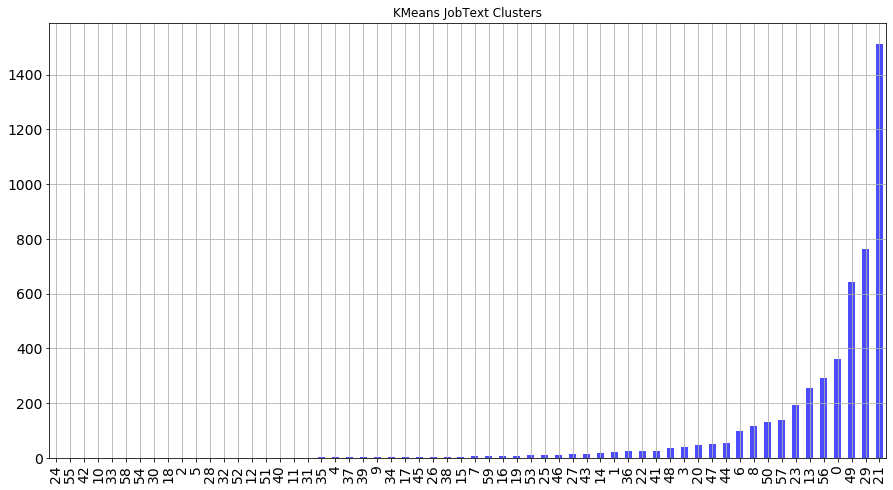

In [52]:
pd.Series(Counter(km.labels_)).sort_values().plot(kind='bar',
                                    rot=90, 
                                    figsize=(15, 8),
                                    fontsize=14,
                                    color='blue',
                                    title='KMeans JobText Clusters',
                                    grid=True,
                                    alpha=0.70);

In [58]:
small_df.loc[small_df['text_uni_6'] == 21, 'CleanJobTitle'].head(20)

16536                                  Test Engineer
87293    Assistant Maintenance Manager - Metropointe
88551                             Highway Technician
72121       Contracts And Procurement Management Ana
Name: CleanJobTitle, dtype: object

In [118]:
cv_mx = CountVectorizer(ngram_range=(1, 1),
                          min_df=8,
                          max_df=0.85,
#                           stop_words=stopwords
    )

In [119]:
%%time

cv_text_mx = cv_mx.fit_transform(small_df['clean_text'])
cv_text_mx

CPU times: user 3.84 s, sys: 990 ms, total: 4.83 s
Wall time: 6.85 s


<10000x13077 sparse matrix of type '<class 'numpy.int64'>'
	with 2304213 stored elements in Compressed Sparse Row format>

In [120]:
cv_text_mx.shape

(10000, 13077)

In [122]:
num_clusters = 50

km_text = KMeans(n_clusters=num_clusters, # how many clusters do we want
                 max_iter=1000, # reshuffle each centroid x n number of times
                 n_init=25, # do the max_iter n number of times
                 random_state=42, # set the seed for reproducible results
                 n_jobs=4 # number of cpu's to use in the computation
           )

In [123]:
%%time

km_text.fit(cv_text_mx)

CPU times: user 447 ms, sys: 829 ms, total: 1.28 s
Wall time: 29min 2s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=50, n_init=25, n_jobs=4, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [124]:
small_df['km_labels'] = km_text.labels_
small_df.head()

,JobDate,CanonEmployer,CleanJobTitle,clean_text,normal_text,normal_titles,km_clusters,km_labels
34685,2011-04-04,URS Corporation,Proposal Manager,Requisition Number: URS50828 Interest Category...,requisition number urs50828 interest category ...,proposal manager,19,34
61200,2011-08-22,Cannery Casino Resorts,Advertising Coordinator,| | | Job Title: Advertising Coordinator City:...,job title advertising coordinator city washing...,advertising coordinator,1,42
55037,2014-10-12,Recruiting Agency,Maintenance Mechanic,Maintenance Mechanic Company: N/A Location: Au...,maintenance mechanic company na location auror...,maintenance mechanic,21,34
9557,2018-08-05,Recruiting Agency,Facility In North Seeking Psychiatric Physicia...,Facility in North Carolina Seeking Psychiatric...,facility in north carolina seeking psychiatric...,facility in north seeking psychiatric physicia...,22,11
90278,2014-01-14,Schoodic Arts For All,Bookkeeper Development Manager,Bookkeeper Development Manager Schoodic Arts f...,bookkeeper development manager schoodic arts f...,bookkeeper development manager,19,42


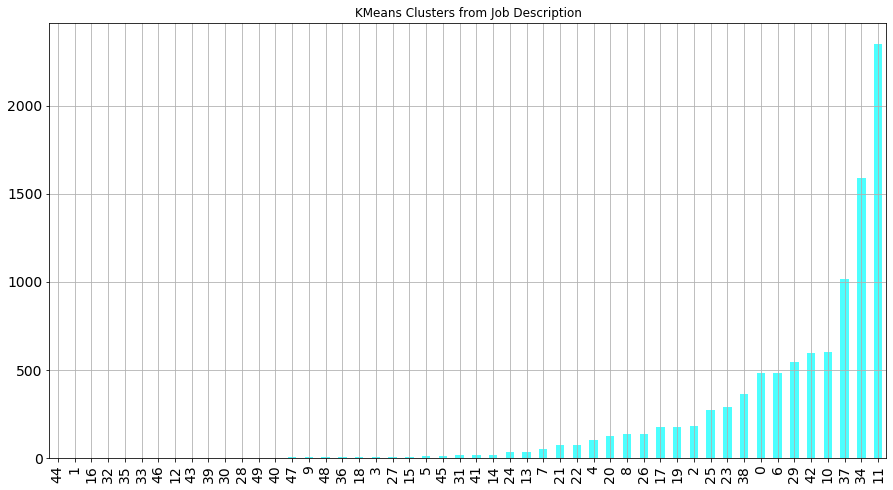

In [126]:
pd.Series(Counter(km_text.labels_)).sort_values().plot(kind='bar',
                                    rot=90, 
                                    figsize=(15, 8),
                                    fontsize=14,
                                    color='cyan',
                                    title='KMeans Clusters from Job Description',
                                    grid=True,
                                    alpha=0.70);

### To Add

1. Distance metrics conditions to satisfy

In [1]:
import hdbscan

In [ ]:
cluster = hdbscan.HDBSCAN().fit(cv_matrix)

In [ ]:
Counter(cluster.labels_)